In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# Load the data
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018]
team_arr, player_arr = [], []
for year in years:
    df_p = pd.read_csv('data/player/boxscores/totals/BR_Player_BoxScores_%d.csv' % year)
    df_p['season'] = year
    player_arr.append(df_p)
    df_t = pd.read_csv('data/team/boxscores/BR_Team_BoxScores_%d.csv' % year)
    df_t['year'] = year
    team_arr.append(df_t)
df_player = pd.concat(player_arr)
df_team = pd.concat(team_arr)

In [3]:
# Compute the score
def apply_bonus_transform(r, num_cats=2):
    val = 0
    if r['points_scored'] >= 10:
        val = val + 1
    if r['defensive_rebounds'] + r['offensive_rebounds'] >= 10:
        val = val + 1
    if r['assists'] >= 10:
        val = val + 1
    if r['steals'] >= 10:
        val = val + 1
    if r['blocks'] >= 10:
        val = val + 1

    if val >= num_cats:
        return 1
    else:
        return 0

df_player['DD'] = df_player.apply(lambda row: apply_bonus_transform(row), axis=1)
df_player['TD'] = df_player.apply(lambda row: apply_bonus_transform(row, num_cats=3), axis=1)
    
df_player['score'] = df_player['made_three_point_field_goals']*.5 + \
        df_player['defensive_rebounds']*1.25 + df_player['offensive_rebounds']*1.25 + \
        df_player['assists']*1.5 + \
        df_player['steals']*2.0 + df_player['blocks']*2.0 + \
        df_player['turnovers']*-0.5 + \
        df_player['DD']*1.5 + df_player['TD']*3.0 + \
        df_player['points_scored']

In [4]:
# Categorize the data then extract
data_df = pd.get_dummies(df_player, columns=['opponent', 'outcome', 'location'])
col_raw = 'made_field_goals|attempted_field_goals|' + \
            'made_three_point_field_goals|attempted_three_point_field_goals|' + \
            'made_free_throws|attempted_free_throws|' + \
            'offensive_rebounds|defensive_rebounds|' + \
            'assists|steals|blocks|turnovers|personal_fouls|' + \
            'points_scored|game_score|plus_minus'
col_cat = 'opponent|outcome|location'
col_tar = 'score'
col_ses = 'season|slug|name|date'
data_df = data_df.filter(regex='%s|%s|%s|%s' % (col_raw, col_cat, col_tar, col_ses))

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVR

def train_model(data_X, data_y):
#     tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    clf = GridSearchCV(
        SVR(), tuned_parameters, scoring='neg_root_mean_squared_error'
    )
    clf.fit(data_X, data_y)
    return clf
# Weighted sum of predictions (weighted more favorably towards later preds)
def compute_sum(v):
    l = [1/(len(v)-i) for i in range(len(v))]
    l = np.array(l)/np.sum(l)
    return np.sum(l*v)

# Build the data based on the sliding window
def construct_dataset(data_df, window=5):
    data_X, data_y = [], []
    for i in range(0, len(data_df)-window):
        X = []
        X.append(data_df[i:i+window].filter(regex='%s|%s' % (col_cat, col_raw)).values.flatten())
        X.append(data_df[i+window:i+window+1].filter(regex='opponent|location').values.flatten())
        data_X.append(np.concatenate(X))
        data_y.append(data_df[i+window:i+window+1]['score'].values[0])
    return data_X, data_y

In [42]:
players = data_df['slug'].value_counts().index
output = []
for player in players:
    # Print the player
    data_df_ = data_df[data_df['slug'] == player]
    print("Working on player: %s" % player)
    # Iterate through the first two years and construct models
    models = []
    for year in years[:-1]:
        # Extract the data
        data_X, data_y = construct_dataset(data_df_[data_df_['season'] == year])
        # Train the model
        if(len(data_X) > 5):
            models.append(train_model(data_X, data_y))
    # For the current season, incrementally build the model and make predictions
    df_curr = data_df_[data_df_['season'] == years[-1]]
    data_X, data_y = construct_dataset(df_curr, window=5)
   
    # Collect the player output
    player_output = []
    start = 10
    if(len(data_X) > start+5):
        # Iterate through, build the model, make weighted predictions
        predictions, actual = [], []
        for i in range(start, len(data_X)):
            # Build the model
            svr = train_model(data_X, data_y)
            # Make the predictions
            preds = []
            for model in models:
                preds.append(model.predict([data_X[i]])[0])
            preds.append(svr.predict([data_X[i]])[0])
            # Compute the final value and append
            predictions.append(compute_sum(preds))
            actual.append(data_y[i])
            # [Date, Player Name, Player Slug, Prediction]
            out = [df_curr[i:i+1]['date'].values[0], 
                     df_curr[i:i+1]['name'].values[0], 
                     df_curr[i:i+1]['slug'].values[0], 
                     predictions[-1]]
            player_output.append(out)
        print("Final score: %0.4f\n" % (mean_squared_error(predictions, actual)))
        output.append(player_output)
    else:
        print("Not enough data for player: %s\n" % player)

Working on player: ilyaser01
Final score: 50.0944

Working on player: breweco01
Final score: 43.1754

Working on player: augusdj01
Final score: 58.4892

Working on player: leeco01
Final score: 51.1114

Working on player: harrito02
Final score: 65.0654

Working on player: sessira01
Final score: 28.6461

Working on player: smithis01
Final score: 44.1559

Working on player: pattepa01
Final score: 47.4663

Working on player: johnsjo02
Final score: 61.6820

Working on player: greenje02
Final score: 33.9156

Working on player: crowdja01
Final score: 39.7382

Working on player: turneev01
Final score: 39.0253

Working on player: monrogr01
Final score: 56.4942

Working on player: ibakase01
Final score: 51.6435

Working on player: booketr01
Final score: 50.9968

Working on player: youngth01
Final score: 65.9110

Working on player: dragigo01
Final score: 59.2418

Working on player: kanteen01
Final score: 73.5791

Working on player: gayru01
Final score: 128.1672

Working on player: morrima02
Final

Not enough data for player: singlky01

Working on player: evansty01
Final score: 87.4337

Working on player: coleno01
Not enough data for player: coleno01

Working on player: hilarne01
Final score: 35.3969

Working on player: rubiori01
Final score: 52.9954

Working on player: holidjr01
Final score: 84.1789

Working on player: anderry01
Final score: 51.6840

Working on player: acyqu01
Final score: 34.6599

Working on player: carrode01
Final score: 64.2754

Working on player: mcgeeja01
Final score: 27.3339

Working on player: jeffeal01
Final score: 142.6598

Working on player: bayleje01
Final score: 15.4612

Working on player: ginobma01
Final score: 41.5843

Working on player: hendege02
Not enough data for player: hendege02

Working on player: scolalu01
Not enough data for player: scolalu01

Working on player: conlemi01
Not enough data for player: conlemi01

Working on player: bassbr01
Not enough data for player: bassbr01

Working on player: loveke01
Final score: 80.7668

Working on play

Not enough data for player: boozeca01

Working on player: covinro01
Final score: 48.5548

Working on player: evansre01
Not enough data for player: evansre01

Working on player: fredeji01
Not enough data for player: fredeji01

Working on player: novakst01
Not enough data for player: novakst01

Working on player: joneste01
Not enough data for player: joneste01

Working on player: vonleno01
Final score: 21.9834

Working on player: poweldw01
Final score: 32.9325

Working on player: blackta01
Final score: 30.2818

Working on player: hayesch01
Not enough data for player: hayesch01

Working on player: rosede01
Final score: 124.2501

Working on player: anthojo01
Not enough data for player: anthojo01

Working on player: lauvejo01
Final score: 38.1000

Working on player: anderal01
Not enough data for player: anderal01

Working on player: wallage01
Not enough data for player: wallage01

Working on player: noelne01
Final score: 38.0370

Working on player: fishede01
Not enough data for player: fish

Final score: 41.3692

Working on player: ferreyo01
Final score: 34.6490

Working on player: harremo01
Final score: 34.4528

Working on player: fieldla01
Not enough data for player: fieldla01

Working on player: pressph01
Not enough data for player: pressph01

Working on player: copelch01
Not enough data for player: copelch01

Working on player: ezelife01
Not enough data for player: ezelife01

Working on player: jenkich01
Not enough data for player: jenkich01

Working on player: hernawi01
Final score: 18.0984

Working on player: mejrisa01
Final score: 22.6156

Working on player: marjabo01
Final score: 48.4065

Working on player: decolna01
Not enough data for player: decolna01

Working on player: grayaa01
Not enough data for player: grayaa01

Working on player: turkohe01
Not enough data for player: turkohe01

Working on player: bynumwi01
Not enough data for player: bynumwi01

Working on player: winslju01
Final score: 32.2781

Working on player: murraja01
Final score: 46.5712

Working on 

Not enough data for player: warriha01

Working on player: hillida01
Not enough data for player: hillida01

Working on player: garredi02
Not enough data for player: garredi02

Working on player: grahatr01
Final score: 9.1478

Working on player: weberbr01
Final score: 10.4658

Working on player: nwabada01
Final score: 14.9171

Working on player: petrojo01
Not enough data for player: petrojo01

Working on player: iveyro01
Not enough data for player: iveyro01

Working on player: wilcoch01
Not enough data for player: wilcoch01

Working on player: whiteis01
Not enough data for player: whiteis01

Working on player: hernaju01
Final score: 27.3535

Working on player: weemsso01
Not enough data for player: weemsso01

Working on player: boganke01
Not enough data for player: boganke01

Working on player: willite01
Not enough data for player: willite01

Working on player: smithno01
Not enough data for player: smithno01

Working on player: beaslma01
Final score: 14.8604

Working on player: johnsch03


Not enough data for player: mcgratr01

Working on player: childjo01
Not enough data for player: childjo01

Working on player: paytoga02
Final score: 0.0100

Working on player: randlch01
Not enough data for player: randlch01

Working on player: balllo01
Final score: 0.0098

Working on player: gladnmi01
Not enough data for player: gladnmi01

Working on player: masonfr01
Final score: 0.0100

Working on player: ortonda01
Not enough data for player: ortonda01

Working on player: reddmi01
Not enough data for player: reddmi01

Working on player: parkean01
Not enough data for player: parkean01

Working on player: maggeco01
Not enough data for player: maggeco01

Working on player: goudean01
Not enough data for player: goudean01

Working on player: buyckdw01
Final score: 54.7317

Working on player: richaqu01
Not enough data for player: richaqu01

Working on player: diopde01
Not enough data for player: diopde01

Working on player: evansja01
Final score: 0.0100

Working on player: naderab01
Final 

Final score: 0.0100

Working on player: willise01
Not enough data for player: willise01

Working on player: hammoaj01
Not enough data for player: hammoaj01

Working on player: najered01
Not enough data for player: najered01

Working on player: reedda01
Final score: 0.0100

Working on player: wallara01
Not enough data for player: wallara01

Working on player: haranlu01
Not enough data for player: haranlu01

Working on player: mitchto02
Not enough data for player: mitchto02

Working on player: gibsojo01
Not enough data for player: gibsojo01

Working on player: henrymy01
Not enough data for player: henrymy01

Working on player: harrimi01
Not enough data for player: harrimi01

Working on player: munfoxa02
Not enough data for player: munfoxa02

Working on player: josepkr01
Not enough data for player: josepkr01

Working on player: fortsco01
Not enough data for player: fortsco01

Working on player: kornelu01
Not enough data for player: kornelu01

Working on player: peteral01
Not enough data f


Working on player: applike01
Not enough data for player: applike01

Working on player: wileyja01
Not enough data for player: wileyja01

Working on player: reidry01
Not enough data for player: reidry01

Working on player: paigema01
Not enough data for player: paigema01

Working on player: roybr01
Not enough data for player: roybr01

Working on player: grayjo01
Not enough data for player: grayjo01

Working on player: rathaxa01
Not enough data for player: rathaxa01

Working on player: mathima01
Not enough data for player: mathima01

Working on player: mccreer01
Not enough data for player: mccreer01

Working on player: chrispa01
Not enough data for player: chrispa01

Working on player: dawsoer01
Not enough data for player: dawsoer01

Working on player: ahearbl01
Not enough data for player: ahearbl01

Working on player: conrowi01
Not enough data for player: conrowi01

Working on player: huntevi01
Not enough data for player: huntevi01

Working on player: costema01
Not enough data for player

In [43]:
output_ = [item for sublist in output for item in sublist]
df_out = pd.DataFrame(output_, columns=['date', 'name', 'slug', 'score_p'])
df_out.to_csv('data/results/svm/svm.out.test1.csv', index=False)

Model Score: 111.5038


[]

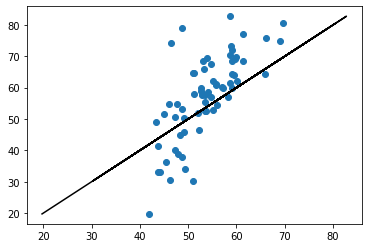

In [241]:
from sklearn.metrics import mean_squared_error    
print("Model Score: %0.4f" % (mean_squared_error(predictions, actual)))
plt.plot(predictions, actual, 'o')
plt.plot(actual, actual, 'k')
plt.plot()

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, make_scorer

auc = make_scorer(roc_auc_score)

# Create the RFE object and compute a cross-validated score.
svr = SVR(kernel="rbf") # SVM Classifier
# rfecv = RFECV(estimator=svc, step = 100, cv=StratifiedKFold(10),
#               scoring=auc, n_jobs = -1, verbose = 5)

svr.fit(train_X, train_y)
predictions = svr.predict(test_X)
plt.plot(predictions, test_y, 'o')
plt.plot()

In [106]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.15, random_state=2)
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(train_X, train_y)
predictions = regr.predict(test_X)

In [ ]:
# player = 'jennibr01'
# # Print the player
# data_df_ = data_df[data_df['slug'] == player]
# print("Working on player: %s" % player)
# # Iterate through the first two years and construct models
# models = []
# for year in years[:-1]:
#     # Extract the data
#     data_X, data_y = construct_dataset(data_df_[data_df_['season'] == year])
#     # Train the model
#     if(len(data_X) > 5):
#         models.append(train_model(data_X, data_y))
# # For the current season, incrementally build the model and make predictions
# df_curr = data_df_[data_df_['season'] == years[-1]]
# data_X, data_y = construct_dataset(df_curr, window=5)

# # Collect the player output
# player_output = []
# start = 10
# if(len(data_X) > start+5):
#     # Iterate through, build the model, make weighted predictions
#     predictions, actual = [], []
    
#     for i in range(start, len(data_X)):
#         # Build the model
#         svr = train_model(data_X, data_y)
#         # Make the predictions
#         preds = []
#         for model in models:
#             preds.append(model.predict([data_X[i]])[0])
#         preds.append(svr.predict([data_X[i]])[0])
#         # Compute the final value and append
#         predictions.append(compute_sum(preds))
#         actual.append(data_y[i])
#         # [Date, Player Name, Player Slug, Prediction]
#         out = [df_curr[i:i+1]['date'], df_curr[i:i+1]['name'], df_curr[i:i+1]['slug'], predictions[-1]]
#         player_output.append(out)
#     print("Final score: %0.4f\n" % (mean_squared_error(predictions, actual)))
#     output.append(player_output)
# else:
#     print("Not enough data for player: %s\n" % player)